<img src="Z_faceting2.jpg">
For any wide-field observation, the celestial sphere within the field of view can be divided into several $n$-planes, or $n$-facets. 

For a given $n$-facet at $n = n_i$, we have

$V(u,v,w)\exp[i2\pi w(n_i-1)] = \int\int \frac{\text{d}l \text{d}m}{n}I(l,m)\exp[-i2\pi(ul+vm)]$

In this way, the brightness on this $n$--facet can be calculated via a two-dimensional inverse Fourier transform from the phase-shifted visibilities $V(u,v,w)\exp[i2\pi w(n_i-1)]$. 

In [94]:
%matplotlib notebook
import numpy as np
from scipy.optimize import leastsq, brent
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from time import process_time
from numpy.linalg import inv
np.set_printoptions(precision=16)

### 1. Read in the data

In [95]:
#########  Read in visibilities ##########
data = np.genfromtxt('simul3d.csv', delimiter = ',')
jj = complex(0,1)
u = data.T[2][1:]
v = data.T[3][1:]
w = data.T[4][1:]
V = data.T[5][1:] + jj*data.T[6][1:]
n_uv = len(u)
uv_max = max(np.sqrt(u**2+v**2))

In [96]:
#### Determine the pixel size ####

X_size = 500 # image size on x-axis
Y_size = 500 # image size on y-axis
X_min = -1.15/2 #You can change X_min and X_max in order to change the pixel size.
X_max = 1.15/2
X = np.linspace(X_min, X_max, num=X_size+1)[0:X_size]
Y_min = -1.15/2 #You can change Y_min and Y_max in order to change the pixel size.
Y_max = 1.15/2
Y = np.linspace(Y_min,Y_max,num=Y_size+1)[0:Y_size]
pixel_resol_x = 180. * 60. * 60. * (X_max - X_min) / np.pi / X_size
pixel_resol_y = 180. * 60. * 60. * (Y_max - Y_min) / np.pi / Y_size
print ("The pixel size on x-axis is ", pixel_resol_x, " arcsec") 

The pixel size on x-axis is  474.4090543683216  arcsec


### 2. Determine the number of facets on $n$-axis

To determine the number of facets $N_{n}$ on the $n$-axis, we revisit the Bayesian resolving power formula proposed in the paper titled 

##### Bayesian Source Descrimination in Radio Interferometry
https://academic.oup.com/mnras/article-abstract/484/1/574/5251988?redirectedFrom=fulltext

We have the Bayesian resolving power as 

$(\Delta x_{ij})^{-1} = \partial_{ij}^2B(\textbf{x})_{|\textbf{x}=\textbf{0}} = 4 \pi^2 \sigma ^2 \sum_k \frac{(u_k)_i(u_k)_j}{\sigma_k^{2}}$, 

therefore, we can obtain the separation between two adjacent $n$-facets as

$\Delta n \leq \sqrt{\Delta x_{22}}$

By use of the Bayesian resolving power formula, we can ensure that $n$-axis is reasonably sampled.

Therefore, the number of $n$-planes is determined by

$N_{n} \geq \frac{n_{\rm max}-n_{\rm min}}{\sqrt{\Delta x_{22}}}$

We usually take $N_{n}$ to be a multiple of a few times the right-hand side, for better sampling on the $n$--axis.


In [97]:
du2 = 4*np.pi**2/n_uv*(sum(u*u))
dv2 = 4*np.pi**2/n_uv*(sum(v*v))
dw2 = 4*np.pi**2/n_uv*(sum(w*w))
duv = 4*np.pi**2/n_uv*(sum(u*v))
duw = 4*np.pi**2/n_uv*(sum(u*w))
dvw = 4*np.pi**2/n_uv*(sum(v*w))
matrix_d = np.array([[du2, duv, duw], [duv, dv2, dvw],[duw, dvw, dw2]])
matrix_d_inv = inv(matrix_d)
dn = np.sqrt(matrix_d_inv[2,2])
print ('The separation between two adjacent n-facets is ',dn)

The separation between two adjacent n-facets is  0.0127311630643


In [98]:
z_range = 1-np.sqrt(1-X_max**2-Y_max**2) # we use z instead of n to match x and y :D
few_times = 2 
Z_n = np.int(np.round(z_range/dn)) * few_times 
print ('We can use ', Z_n, 'n-facets')

We can use  66 n-facets


In [99]:
### n value of each facet
z_values = [-z_range/Z_n*i for i in range(Z_n)] # max(z) = 0

### 3. Gridding Process

#### 3.1 Predefined Function

In [100]:
def make_evaluation_grids(W, M, N):
    """Generate vectors nu and x on which the gridder and gridding correction functions need to be evaluated.
        W is the number of integer gridpoints in total 
        M determines the sampling of the nu grid, dnu = 1/(2*M)
        N determines the sampling of the x grid, dx = 1/(2*N)
    """
    nu = (np.arange(W * M, dtype=float) + 0.5) / (2 * M)
    x = np.arange(N+1, dtype=float)/(2 * N)
    return nu, x

def calc_gridder_as_C(h, x0, nu, W):
    # Calculate gridding function C(l,nu) from gridding correction h(x) evaluated at (n+1) x_0/N where n is in range 0,...,N-1. 
    #  We assume that h(0)=1 for normalization, and use the trapezium rule for integration.
    # The gridding function is calculated for l=(1-W)/2 to (W-1)/2 at points nu
    factor = 1./np.sqrt(2.)
    M = len(nu)
    C = np.zeros((W, M), dtype=float)
    N = len(h)
    B = np.zeros((2 * N + 2, W))
    x = x0 * np.arange(0, N+1, dtype=float)/N
    dx = x0 / N
    h_ext = np.concatenate(([1.0], h))
    
    rhs = np.r_[np.ones(N + 1, dtype=float), np.zeros(N + 1, dtype=float)]
    rhs[0] = rhs[0]*factor
    rhs[N] = rhs[N]*factor

    for m, nu_val in enumerate(nu):
        for r in range(W):
            k = r - (W/2) + 1
            B[:N+1, r] = h_ext * np.cos(2 * np.pi * (k - nu_val) * x)
            B[N+1:, r] = h_ext * np.sin(2 * np.pi * (k - nu_val) * x)
        B[0, :] = B[0, :]*factor
        B[N, :] = B[N, :]*factor
        B[N+1, :] = B[N+1, :]*factor
        B[2*N+1, :] = B[2*N+1, :]*factor
#        q, r = np.linalg.qr(B)
#        C[:,m] = solve_triangular(r,np.dot(q.transpose(),rhs))
        C[:,m] = np.linalg.lstsq(B, rhs)[0]
    return C

def calc_gridder(h, x0, nu, W):
    # Calculate gridder function on a grid nu which should have been generated using make_evaluation_grids
    #  The array h is the result of an optimization process for the gridding correction function evaluated
    #  on a relatively coarse grid extending from 0 to x0
    C = calc_gridder_as_C(h, x0, nu, W)
    gridder = np.zeros(M*W, dtype=float)
    for m in range(M):
        for rp in range(0, W):
            lp = rp - (W/2) + 1
            indx = int(m - 2*lp*M)
            if indx >= 0:
                gridder[indx] = C[rp, m]
            else:
                gridder[-indx-1] = C[rp, m]
    return gridder

def gridder_to_C(gridder, W):
    """Reformat gridder evaluated on the nu grid returned by make_evaluation_grids into the sampled C function 
    which has an index for the closest gridpoint and an index for the fractional distance from that gridpoint
    """
    M = len(gridder) // W
    C = np.zeros((W, M), dtype=float)
    for r in range(0, W):
        l = r - (W/2) + 1
        indx = (np.arange(M) - 2 * M * l).astype(int)
        # Use symmetry to deal with negative indices
        indx[indx<0] = -indx[indx<0] - 1
        C[r, :] = gridder[indx]
    return C
    
def gridder_to_grid_correction(gridder, nu, x, W):
    """Calculate the optimal grid correction function from the gridding function. The vectors x and nu should
    have been constructed using make_evaluation_grids"""
    M = len(nu) // W
    N = len(x) - 1
    dnu = nu[1] - nu[0]
    C = gridder_to_C(gridder, W)
    c = np.zeros(x.shape, dtype=float)
    d = np.zeros(x.shape, dtype=float)
    for n, x_val in enumerate(x):
        for rp in range(0, W):
            lp = rp - (W/2) + 1
            for r in range(0, W):
                l = r - (W/2) + 1
                d[n] += np.sum(C[rp, :] * C[r, :] * np.cos(2 * np.pi * (lp - l) * x_val)) * dnu
            c[n] += np.sum(C[rp, :] * np.cos(2 * np.pi * (lp - nu[:M]) * x_val)) * dnu
    return c/d


#### 3.2 Calculate gridding values for the given uvw

In [101]:
### The calculated $h$ with $W = 6$ and $x_0=0.25$
opt6 = dict(W = 6, x0=0.25, h=np.array([
    1.0001930023325103,  1.0007722487834718,  1.0017384582470565,
    1.0030928306497886,  1.0048370496094119,  1.006973286170906 ,
    1.0095042036335624,  1.0124329634778302,  1.0157632324212278,
    1.0194991906233397,  1.0236455410561094,  1.0282075201008483,
    1.033190909366273 ,  1.0386020488054259,  1.0444478511548989,
    1.0507358177532391,  1.0574740557831654,  1.0646712970185641,
    1.0723369181167883,  1.0804809625436269,  1.0891141642026927,
    1.0982479728515449,  1.1078945814002472,  1.1180669551825217,
    1.1287788633171774,  1.1400449122631175,  1.1518805816930127,
    1.164302262836624 ,  1.1773272994022188,  1.1909740312694896,
    1.2052618410867355,  1.220211203987587 ,  1.2358437405714804,
    1.2521822734177863,  1.2692508872950534,  1.2870749933531256,
    1.3056813975329964,  1.3250983734891064,  1.345355740288839 ,
    1.3664849452934122,  1.3885191524603193,  1.4114933365321043,
    1.4354443834948476,  1.4604111977049021,  1.4864348162134051,
    1.513558530761332 ,  1.5418280180050101,  1.5712914785751284,
    1.6019997856026427,  1.6340066433994047,  1.6673687570562927,
    1.7021460137842996,  1.7384016768275126,  1.7762025929639036,
    1.8156194145769096,  1.8567268374316457,  1.8996038553867987,
    1.9443340333039465,  1.9910057996541108,  2.0397127602994884,
    2.0905540351680947,  2.1436346196866345,  2.1990657728474763,
    2.2569654342222729]))

Nfft = 500
W, x0, h = opt6["W"], opt6["x0"], opt6["h"] 

In [102]:
im_size = 500
u_grid = u  * (X_max - X_min) + im_size//2
v_grid = v  * (Y_max - Y_min) + im_size//2
R = W//2
C_u = []
C_v = []
## Calculating gridding values for each vis data
t1_start = process_time() 
for k in range(0,n_uv):
    tempu = u_grid[k] - np.floor(u_grid[k])
    tempv = v_grid[k] - np.floor(v_grid[k])
    C_u += [calc_gridder_as_C(h, x0, np.asarray([tempu]), W)]
    C_v += [calc_gridder_as_C(h, x0, np.asarray([tempv]), W)]

t1_stop = process_time()   
print("Elapsed time during the gridding value calculation in seconds:", t1_stop-t1_start)  

Elapsed time during the gridding value calculation in seconds: 5.795991999999956


#### 3.3 Gridding process

In [103]:
V_grid = np.zeros((Z_n,im_size,im_size),dtype = np.complex_) #gridded visibility
V_phaseshift = np.zeros(n_uv)
bEAM_phaseshift = np.zeros(n_uv)
B_grid = np.zeros((Z_n,im_size,im_size),dtype = np.complex_) 
t2_start = process_time() 
for z_size in range(Z_n):
    z0 = z_values[z_size]
    print ('This is the ', z_size, 'th facet out of ',Z_n,' facets.\n')
    for k in range(0,n_uv):
        phase_V = 2*np.pi*jj*(w[k]*z0)
        V_phaseshift = V[k] * np.exp(phase_V)
        bEAM_phaseshift = np.exp(phase_V)
        C_uk = C_u[k]
        C_vk = C_v[k]
        u_index = np.int(np.floor(u_grid[k]))
        v_index = np.int(np.floor(v_grid[k]))
        for m in range(-R+1,R+1):
            for n in range(-R+1,R+1):
                V_grid[z_size,u_index+m,v_index+n] += C_uk[m+R-1,0] * C_vk[n+R-1,0] * V_phaseshift 
                B_grid[z_size,u_index+m,v_index+n] += C_uk[m+R-1,0] * C_vk[n+R-1,0] * bEAM_phaseshift

t2_stop = process_time()   
print("Elapsed time during the gridding value calculation in seconds:", t2_stop-t2_start)  

This is the  0 th facet out of  66  facets.

This is the  1 th facet out of  66  facets.

This is the  2 th facet out of  66  facets.

This is the  3 th facet out of  66  facets.

This is the  4 th facet out of  66  facets.

This is the  5 th facet out of  66  facets.

This is the  6 th facet out of  66  facets.

This is the  7 th facet out of  66  facets.

This is the  8 th facet out of  66  facets.

This is the  9 th facet out of  66  facets.

This is the  10 th facet out of  66  facets.

This is the  11 th facet out of  66  facets.

This is the  12 th facet out of  66  facets.

This is the  13 th facet out of  66  facets.

This is the  14 th facet out of  66  facets.

This is the  15 th facet out of  66  facets.

This is the  16 th facet out of  66  facets.

This is the  17 th facet out of  66  facets.

This is the  18 th facet out of  66  facets.

This is the  19 th facet out of  66  facets.

This is the  20 th facet out of  66  facets.

This is the  21 th facet out of  66  facets.

#### 3.4 FFT process

In [104]:
I_image = np.zeros([Z_n,im_size,im_size],dtype = np.complex_)
B_image = np.zeros([Z_n,im_size,im_size],dtype = np.complex_)

for z_size in range(Z_n):
    II = np.fft.ifftshift(V_grid[z_size])
    II = np.fft.ifftn(II)
    II = np.fft.ifftshift(II)
    I_image[z_size] = II
    SB = np.fft.ifftshift(B_grid[z_size])
    SB = np.fft.ifftn(SB)
    SB = np.fft.ifftshift(SB)
    B_image[z_size] = SB


#### 3.5 Calculate the correcting function and obtain the FFT images

In [105]:
## Calculating the correcting function h_map
M = 32
nu, x = make_evaluation_grids(W, M, Nfft/2)
gridder = calc_gridder(h, x0, nu, W)
grid_correction = gridder_to_grid_correction(gridder, nu, x, W) 

h_map = np.zeros(Nfft, dtype=float)
h_map[Nfft//2:] = grid_correction[:Nfft//2]
h_map[:Nfft//2] = grid_correction[:0:-1]

## correcting the FFT Dirty Beam
B_image_corrected = np.zeros([Z_n,im_size,im_size],dtype = np.complex_)
for z_size in range(Z_n):
    print ('This is the ', z_size, 'th facet out of ',Z_n,' facets.\n')
    for i in range(0,im_size):
        for j in range(0,im_size):
            B_image_corrected[z_size,i,j] = B_image[z_size,i,j] * h_map[i] * h_map[j]


## correcting the FFT Dirty Map
I_image_corrected = np.zeros([Z_n,im_size,im_size],dtype = np.complex_)
for z_size in range(Z_n):
    print ('This is the ', z_size, 'th facet out of ',Z_n,' facets.\n')
    for i in range(0,im_size):
        for j in range(0,im_size):
            I_image_corrected[z_size,i,j] = I_image[z_size,i,j] * h_map[i] * h_map[j]


This is the  0 th facet out of  66  facets.

This is the  1 th facet out of  66  facets.

This is the  2 th facet out of  66  facets.

This is the  3 th facet out of  66  facets.

This is the  4 th facet out of  66  facets.

This is the  5 th facet out of  66  facets.

This is the  6 th facet out of  66  facets.

This is the  7 th facet out of  66  facets.

This is the  8 th facet out of  66  facets.

This is the  9 th facet out of  66  facets.

This is the  10 th facet out of  66  facets.

This is the  11 th facet out of  66  facets.

This is the  12 th facet out of  66  facets.

This is the  13 th facet out of  66  facets.

This is the  14 th facet out of  66  facets.

This is the  15 th facet out of  66  facets.

This is the  16 th facet out of  66  facets.

This is the  17 th facet out of  66  facets.

This is the  18 th facet out of  66  facets.

This is the  19 th facet out of  66  facets.

This is the  20 th facet out of  66  facets.

This is the  21 th facet out of  66  facets.

<IPython.core.display.Javascript object>


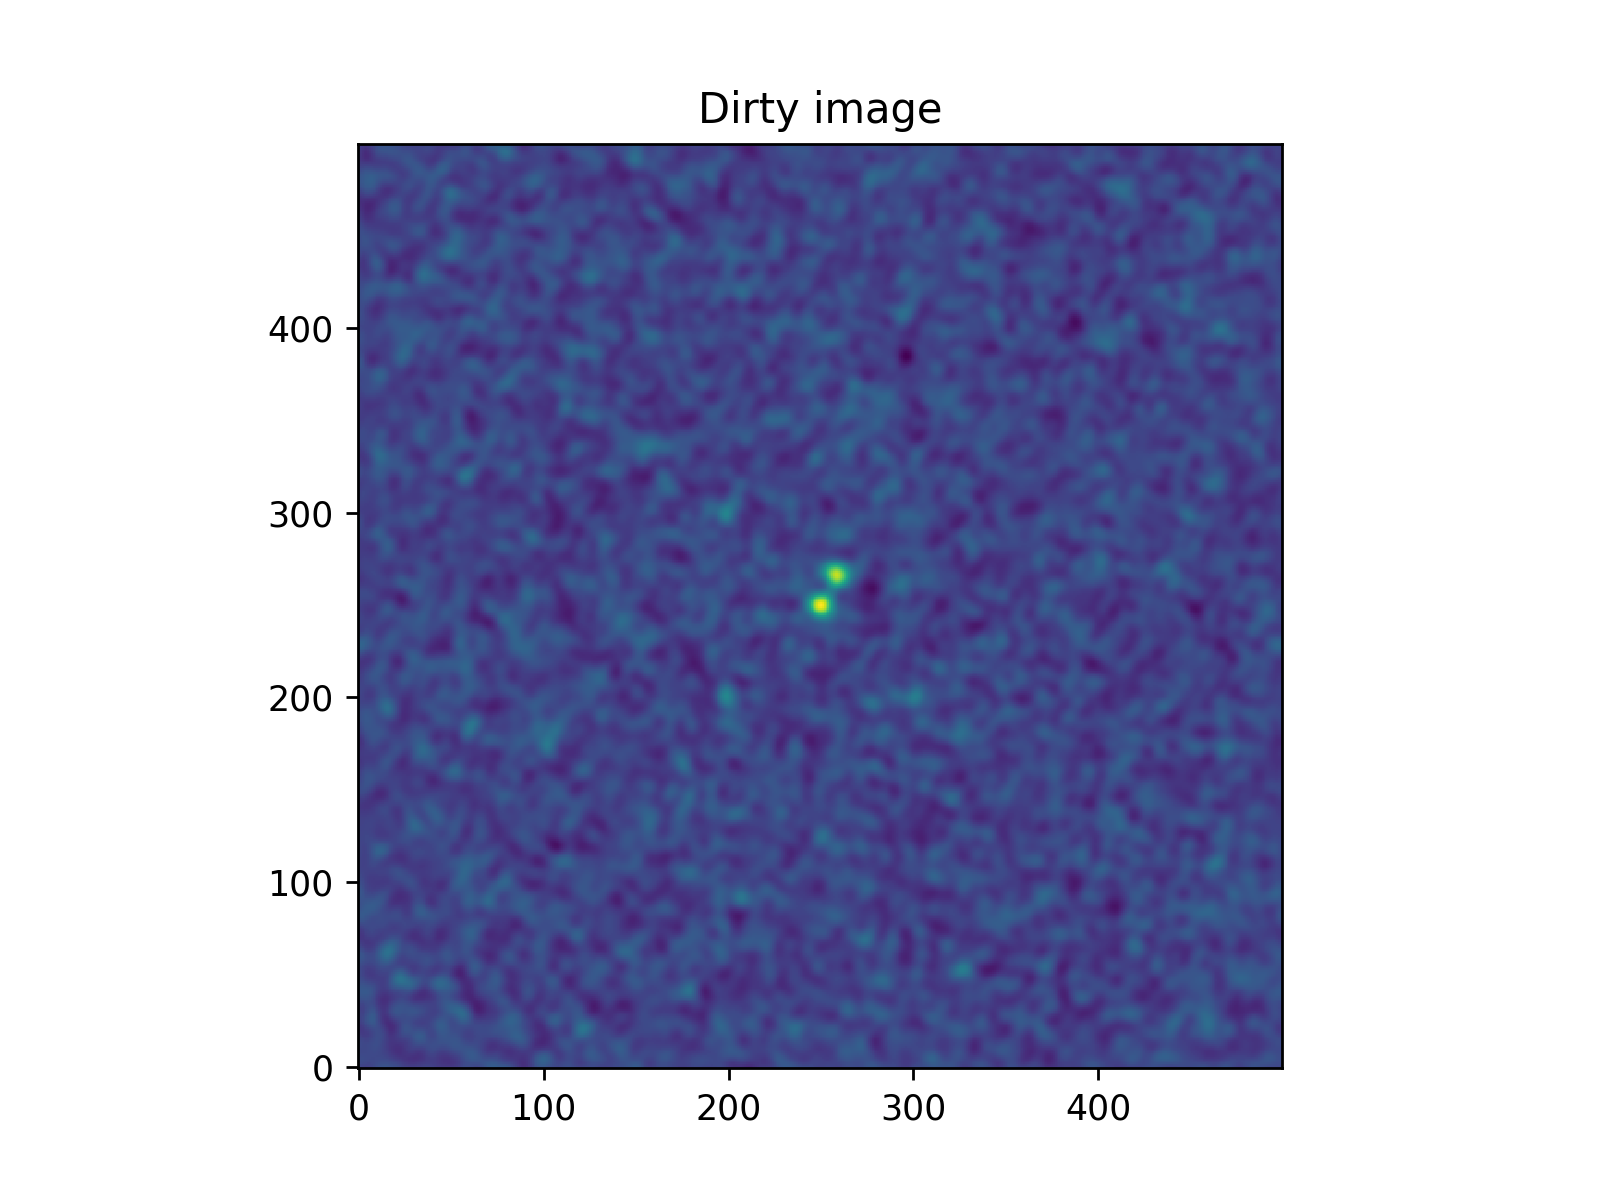

<IPython.core.display.Javascript object>


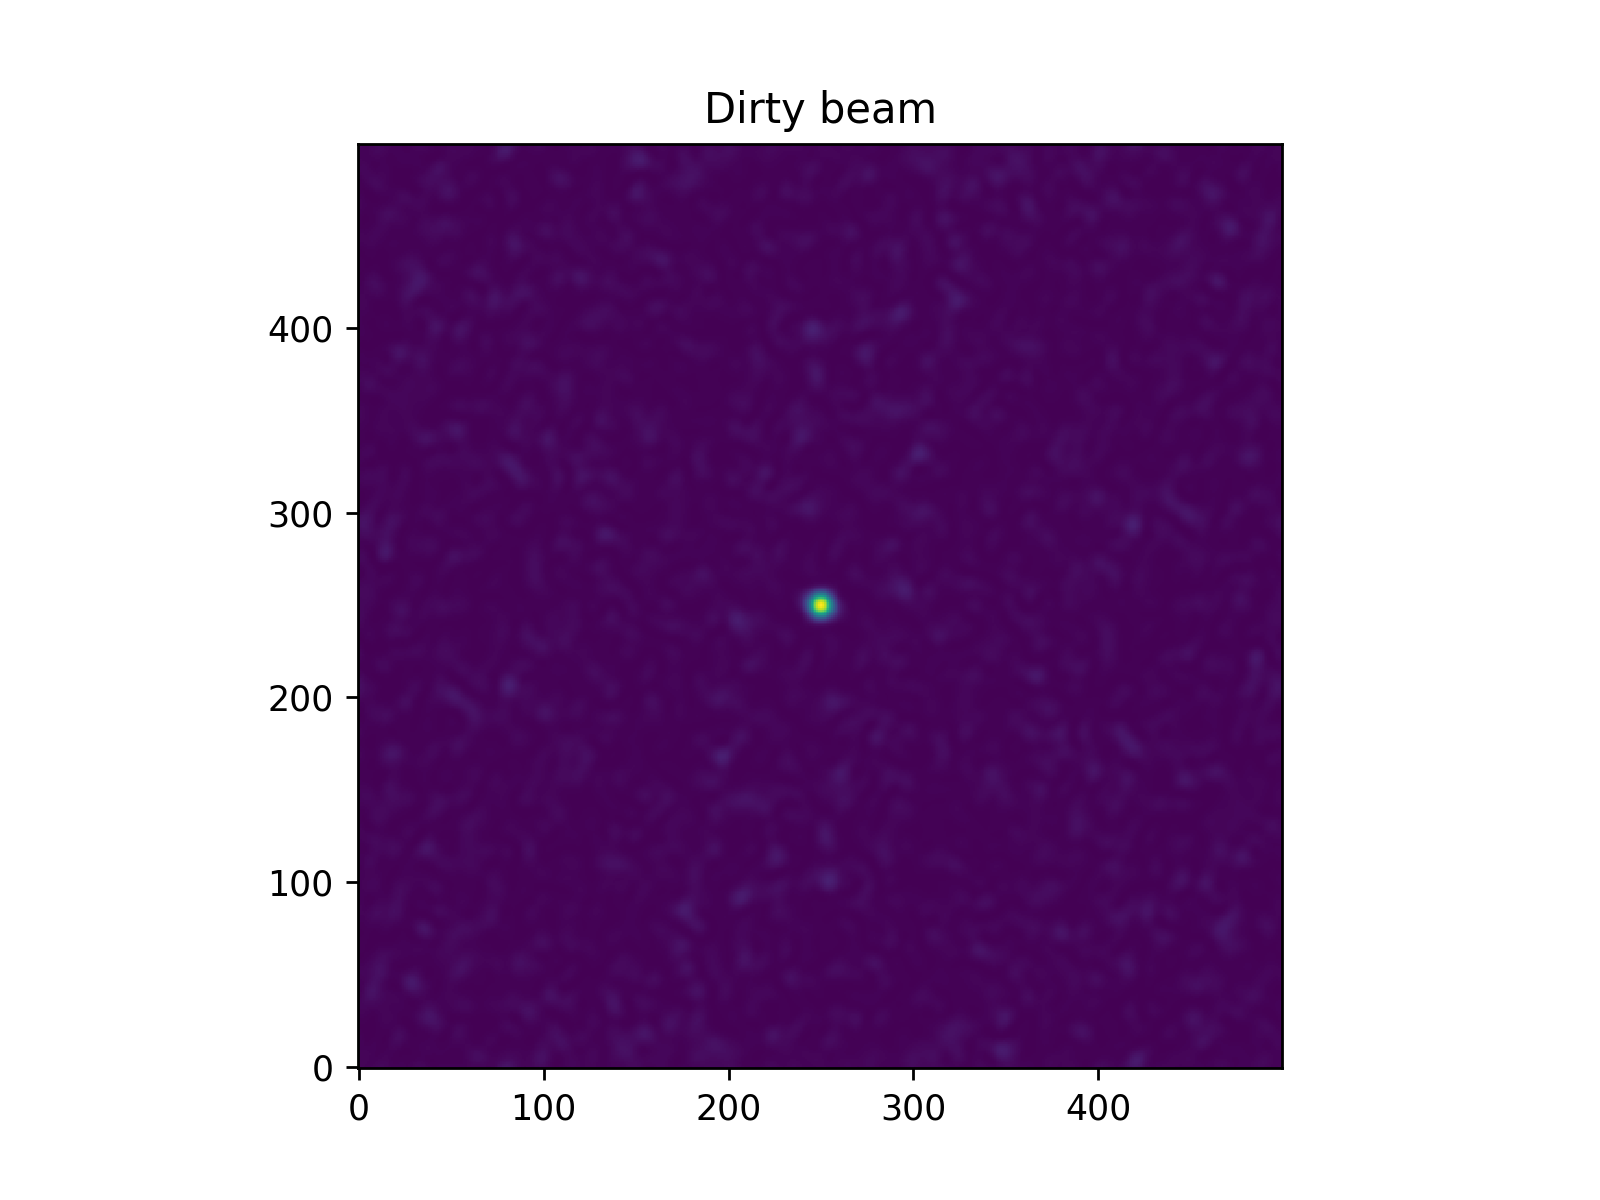

In [106]:
plt.figure()
plt.imshow(I_image_corrected[0].real, origin = 'lower')
plt.title('Dirty image')
plt.figure()
plt.imshow(B_image_corrected[0].real, origin = 'lower')
plt.title('Dirty beam')
plt.show()

#### 3.6 Crop and plot the FFT images

In [107]:
## Crop the two images (the cropping can be done before applyting the correcting function to save computational cost)
I_image_crop = np.zeros([Z_n,im_size//2,im_size//2],dtype = np.complex_)
B_image_crop = np.zeros([Z_n,im_size//2,im_size//2],dtype = np.complex_)

for z_size in range(Z_n):
    temp = np.delete(I_image_corrected[z_size],np.s_[0:X_size//4],0)
    temp = np.delete(temp,np.s_[X_size//2:int(X_size * 0.75)],0)
    temp = np.delete(temp,np.s_[0:Y_size//4],1)
    I_image_crop[z_size] = np.delete(temp,np.s_[Y_size//2:int(Y_size * 0.75)],1)

I_image_crop = I_image_crop*im_size*im_size/n_uv
for z_size in range(Z_n):
    temp = np.delete(B_image_corrected[z_size],np.s_[0:X_size//4],0)
    temp = np.delete(temp,np.s_[X_size//2:int(X_size * 0.75)],0)
    temp = np.delete(temp,np.s_[0:Y_size//4],1)
    B_image_crop[z_size] = np.delete(temp,np.s_[Y_size//2:int(Y_size * 0.75)],1)

B_image_crop = B_image_crop*im_size*im_size/n_uv

<IPython.core.display.Javascript object>


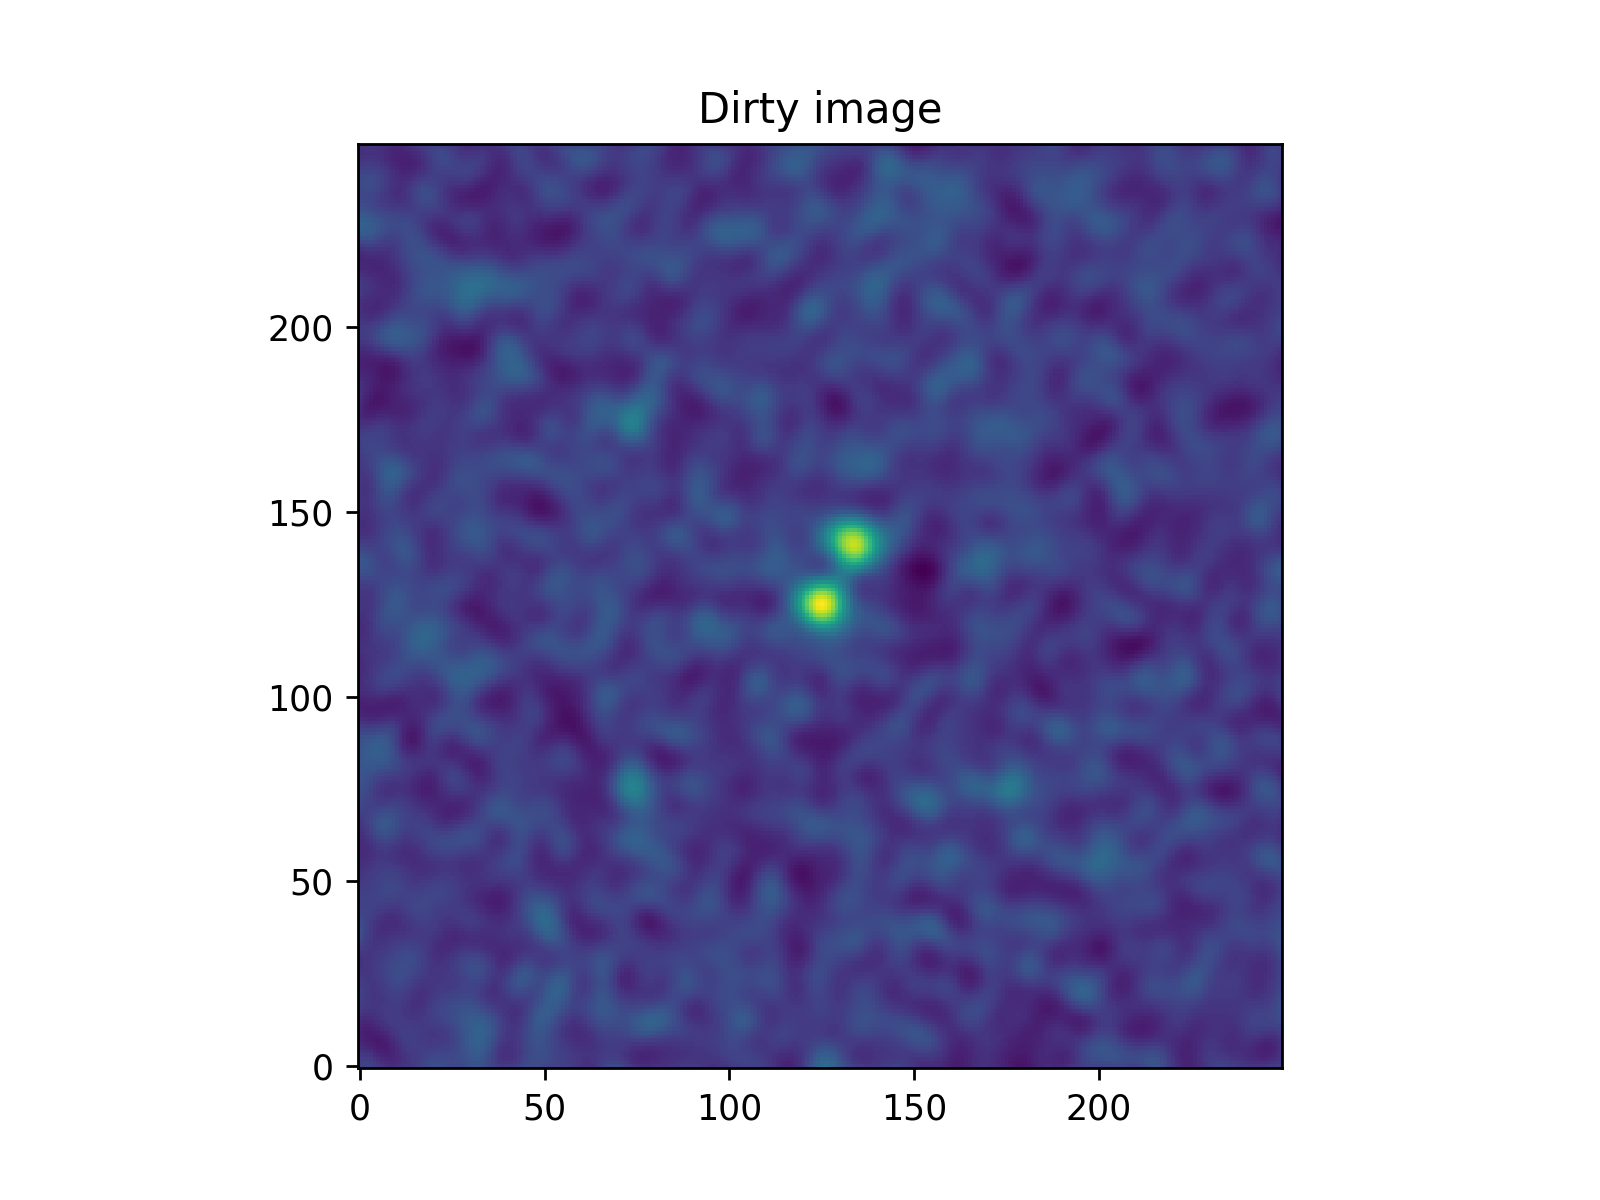

<IPython.core.display.Javascript object>


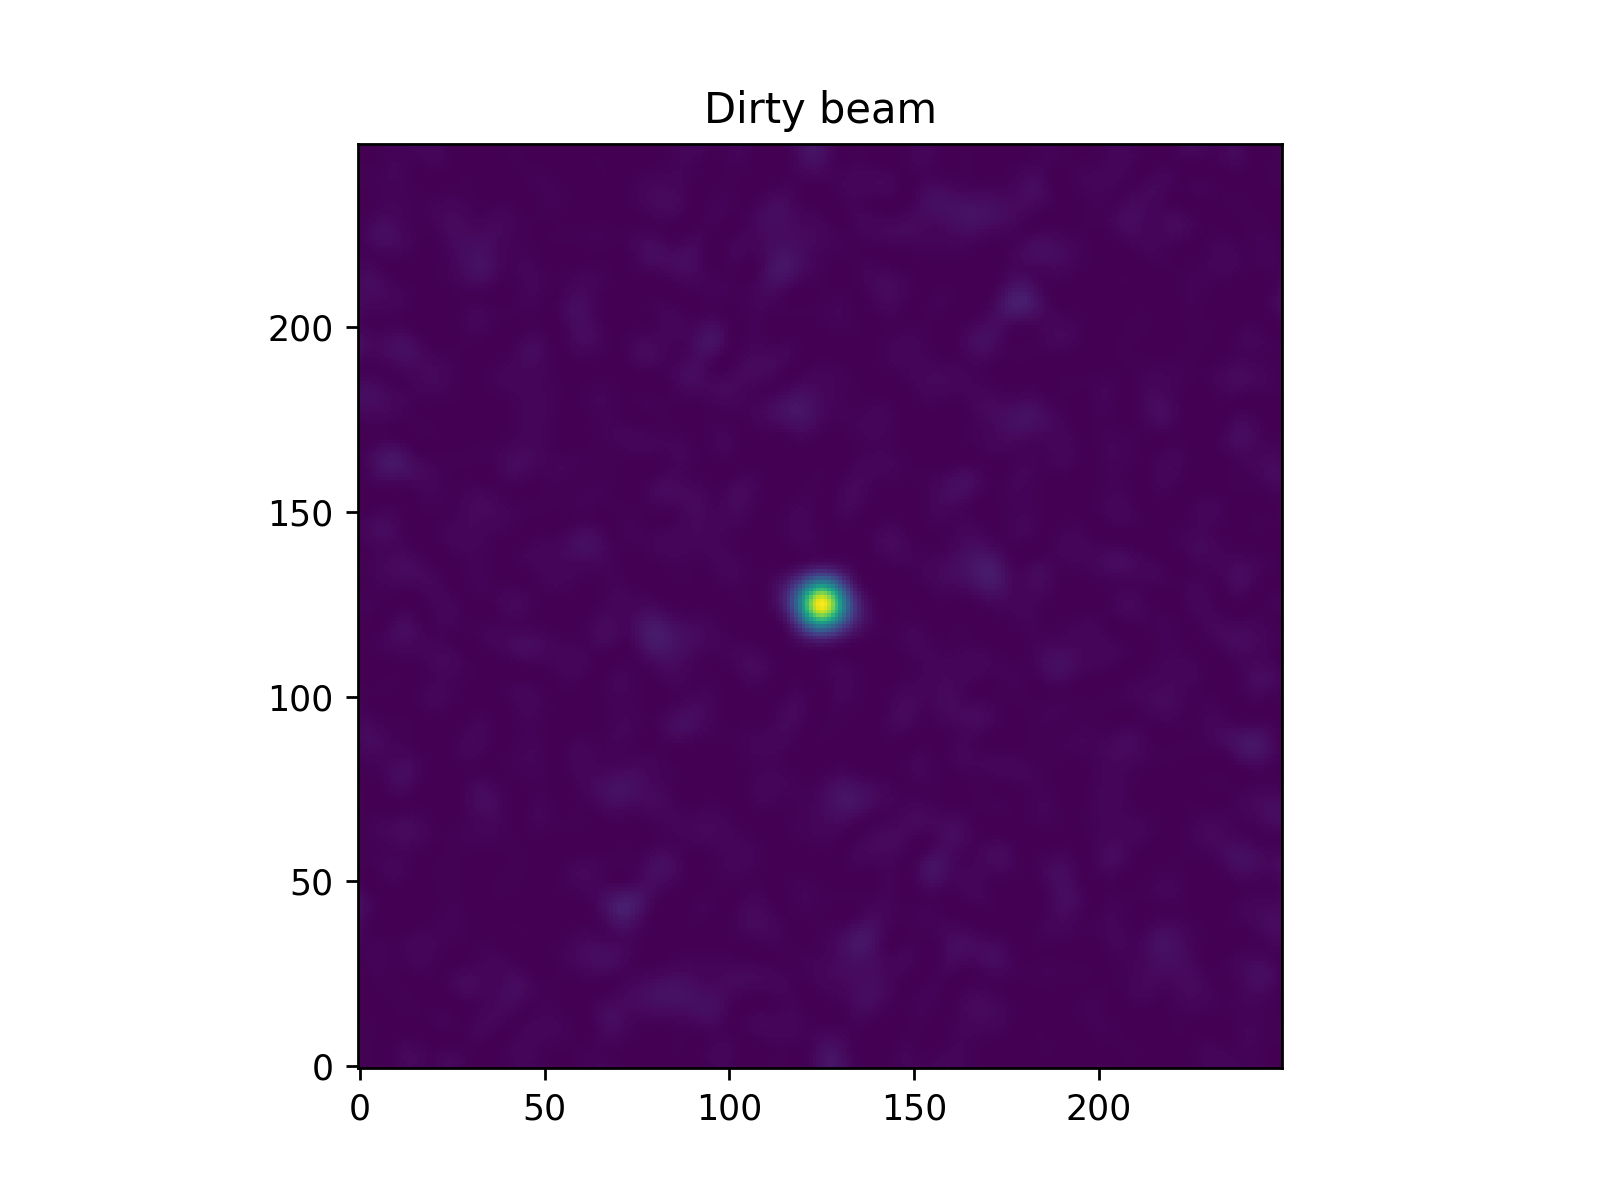

In [108]:
plt.figure()
plt.imshow(I_image_crop[0].real, origin = 'lower')
plt.title('Dirty image')
plt.figure()
plt.imshow(B_image_crop[0].real, origin = 'lower')
plt.title('Dirty beam')
plt.show()

### 4 Make DFT images

In [110]:
X_size = 250
Y_size = 250
im_size = 500
X_min = -1.15/4
X_max = 1.15/4
X = np.linspace(X_min, X_max, num=X_size+1)[0:X_size]
Y_min = -1.15/4
Y_max = 1.15/4
Y = np.linspace(Y_min,Y_max,num=Y_size+1)[0:Y_size]
pixel_resol_x = 180. * 60. * 60. * (X_max - X_min) / np.pi / X_size
pixel_resol_y = 180. * 60. * 60. * (Y_max - Y_min) / np.pi / Y_size
print ("The pixel size on x-axis is ", pixel_resol_x, " arcsec") 

The pixel size on x-axis is  474.4090543683216  arcsec


In [ ]:
I_sum = np.zeros([Z_n,X_size,Y_size],dtype = np.complex_)
SB_sum = np.zeros([Z_n,X_size,Y_size],dtype = np.complex_)

for z_i in range(Z_n):
    t1_start = process_time() 
    print ('This is the ', z_i, 'th level facet out of ',Z_n,' facets.\n')
    z0 = z_values[z_i]
    for x_size in range(0,X_size):
        for y_size in range(0,Y_size):
            I_sum[z_i,x_size,y_size] = complex(0. ,0.)
            SB_sum[z_i,x_size,y_size] = complex(0. ,0.)
            x0 = X[x_size]
            y0 = Y[y_size]
            for i in range(0,n_uv):
                E = 2*np.pi*jj*(u[i]*x0 + v[i]*y0 + w[i]*z0)
                I_sum[z_i,x_size,y_size] += V[i]*np.exp(E)
                SB_sum[z_i,x_size,y_size] += np.exp(E)
    SB_sum[z_i] = SB_sum[z_i]/n_uv
    I_sum[z_i] = I_sum[z_i]/n_uv
    t1_stop = process_time()   
    print("Elapsed time during the gridding value calculation in seconds:", t1_stop-t1_start)  

This is the  0 th level facet out of  66  facets.

Elapsed time during the gridding value calculation in seconds: 1296.70072
This is the  1 th level facet out of  66  facets.

Elapsed time during the gridding value calculation in seconds: 1272.2677959999996
This is the  2 th level facet out of  66  facets.



In [116]:
I_sum[2] - I_image_crop[2]

array([[ -2.6566988231223565e+01 +8.3455090233745705e+02j,
          9.3485976227741688e+01 +9.9905549782832031e+02j,
          1.3417451225228328e+02 +1.0729423865364215e+03j, ...,
         -3.7806011772388523e+01 -1.2932947447829932e+02j,
          1.1859124572452124e+02 -3.4088317834395787e+02j,
          2.7041004020850932e+02 -5.1396395876888835e+02j],
       [  7.6188056359179148e+00 +7.9672821444026727e+02j,
          9.3428023163422083e+01 +9.4884218534012507e+02j,
          9.9653459379785161e+01 +1.0192623180405462e+03j, ...,
         -1.9679920763267748e+02 -1.8020770678474591e+01j,
         -2.8014346492039508e+01 -2.3178246967857248e+02j,
          1.3724749945632408e+02 -3.9592605312768700e+02j],
       [ -7.1790495618792205e-01 +7.3955280345349320e+02j,
          4.5787936664769205e+01 +8.8338887541510474e+02j,
          1.4081148593388246e+01 +9.5755407220600114e+02j, ...,
         -3.8614551943143493e+02 +1.4471376390432337e+02j,
         -2.0660321439980467e+02 -4.764